## Data and Package Importing

In [1]:
from QC import *
sc.settings.set_figure_params(dpi=80)

In [18]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Load labeled data

In [2]:
%time s1 = sc.read_h5ad('data/3247-AS-1-GCCAAT_S1_labeled.h5ad')

CPU times: user 8.23 s, sys: 1.69 s, total: 9.92 s
Wall time: 10.2 s


In [3]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p normalization
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization
sc.tl.pca(s1, n_comps=100) # perform PCA

CPU times: user 2min 20s, sys: 8.82 s, total: 2min 28s
Wall time: 35.4 s


In [4]:
# binarize droplet labels to see how classifiers can detect live cells 
s1.obs['label_bin'] = 0
s1.obs.loc[s1.obs['label']!='live', 'label_bin'] = 0
s1.obs.loc[s1.obs['label']=='live', 'label_bin'] = 1

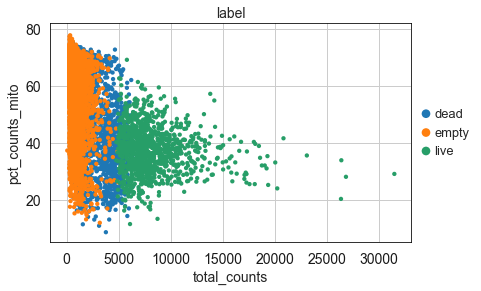

In [5]:
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='label', size=75)

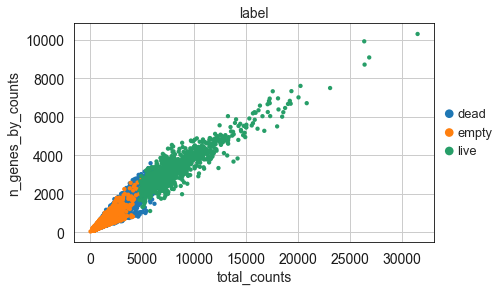

In [6]:
sc.pl.scatter(s1, x='total_counts', y='n_genes_by_counts', color='label', size=75)

---
### Machine Learning Classifiers

Test using wrapper function from `ml_utils.py`

In [7]:
s1.obs['label_bin'].unique() # order of labels for plots

array([1, 0])

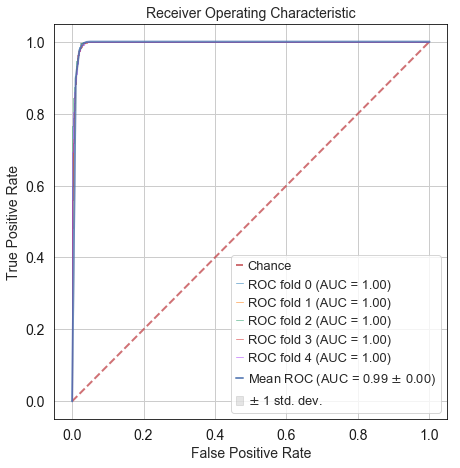

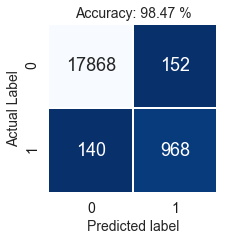

CPU times: user 2min 11s, sys: 9.6 s, total: 2min 20s
Wall time: 23.9 s


In [8]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
lr_out = roc_kfold(clf=lr, X=s1.obsm['X_pca'], y=s1.obs['label_bin'], k=5, seed=18)

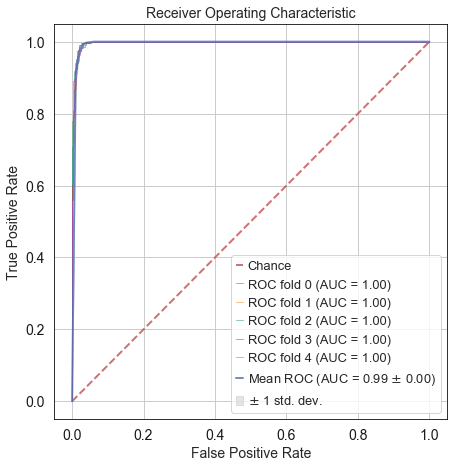

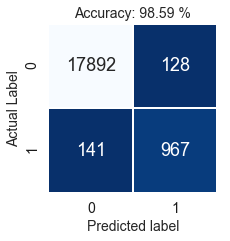

CPU times: user 1min, sys: 166 ms, total: 1min
Wall time: 1min


In [9]:
%%time
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc_out = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['label_bin'], k=5, seed=18)

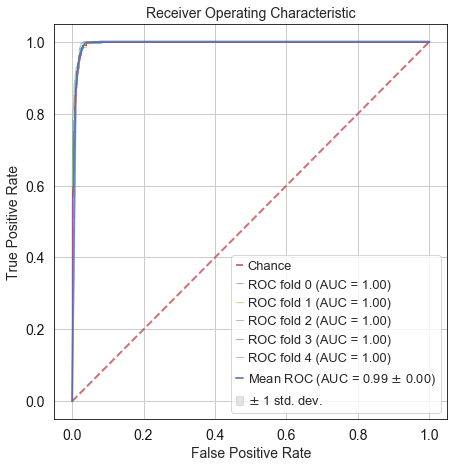

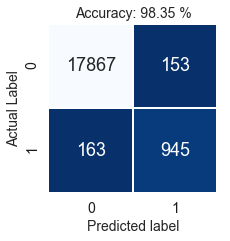

CPU times: user 35.4 s, sys: 137 ms, total: 35.5 s
Wall time: 35 s


In [10]:
%%time
# AdaBoost Classifier
abc = AdaBoostClassifier()
abc_out = roc_kfold(clf=abc, X=s1.obsm['X_pca'], y=s1.obs['label_bin'], k=5, seed=18)

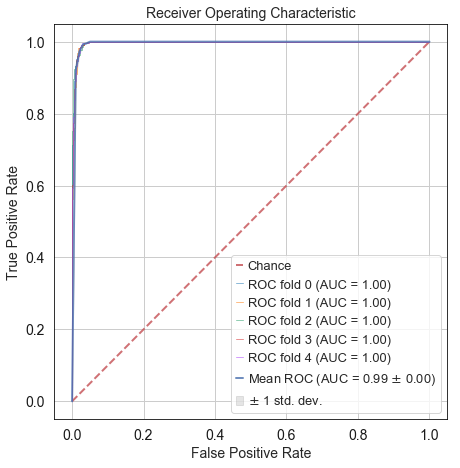

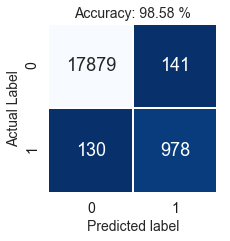

CPU times: user 37 s, sys: 146 ms, total: 37.1 s
Wall time: 36.6 s


In [11]:
%%time
# XGBoost Classifier
xgb = XGBClassifier()
xgb_out = roc_kfold(clf=xgb, X=s1.obsm['X_pca'], y=s1.obs['label_bin'], k=5, seed=18)

---

Now, we can optimize the __Gradient Boosting Classifier__ hyperparameters using `RandomizedSearchCV` to tweak the classifier for the best result and compare optimized classifier.

In [12]:
from pprint import pprint

In [13]:
# Generate grid of hyperparameters to test
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
loss = ['deviance', 'exponential']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# learning rate
learning_rate = np.linspace(0.1, 1, 10)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'loss': loss,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'loss': ['deviance', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [14]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=18, n_jobs = -1)
# Fit the random search model
gbc_random.fit(s1.obsm['X_pca'], s1.obs['label_bin'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.6s
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.2min finished


CPU times: user 12.6 s, sys: 1.26 s, total: 13.8 s
Wall time: 31min 16s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [15]:
gbc_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'loss': 'exponential',
 'learning_rate': 0.30000000000000004}

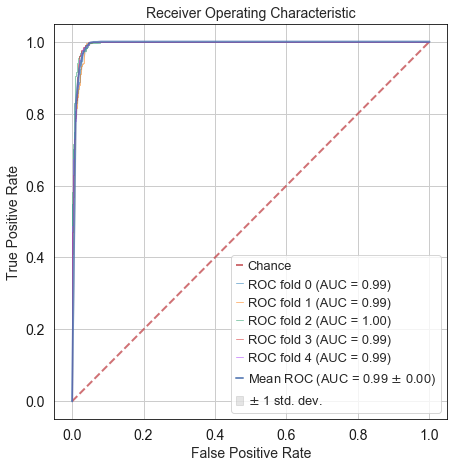

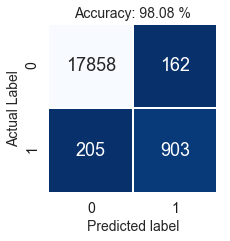

In [16]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=30, loss='exponential', learning_rate=0.3)
mets = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['label_bin'], k=5, seed=18)